<a href="https://colab.research.google.com/github/roshan-k-patel/APCOMP2090A-workbooks/blob/master/2090_sec12_gradboosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science

## Section 12: Gradient Boosting & AdaBoost


**Harvard University**<br/>
**Fall 2025**<br/>
<hr style="height:2pt">

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_squared_error
from sklearn import datasets
from sklearn.datasets import make_blobs
import time

from warnings import simplefilter
simplefilter('ignore', category=UserWarning) # ignore 'fit without feature names' warning
simplefilter('ignore', category=FutureWarning) # ignore XGBoost warning about is_categorical_dtype

In [ ]:
import os
import subprocess

# Define the name of the zip file containing your assets
assets_zip_name = "notebook_assets.zip"

# Define the directories that should be present after extraction
expected_dirs = ["data", "fig"]

# Construct the raw GitHub URL for the zip file
github_raw_url = f"https://github.com/Harvard-CS1090A/2025-public/raw/main/sec12/{assets_zip_name}"

# Check if running in Google Colab
if 'COLAB_GPU' in os.environ:
    print("Running in Google Colab. Checking for necessary files...")

    # Check if the expected directories already exist
    all_dirs_exist = True
    for d in expected_dirs:
        if not os.path.isdir(d):
            all_dirs_exist = False
            break

    if all_dirs_exist:
        print("Required directories already exist. Skipping download.")
    else:
        print(f"Required directories not found. Downloading {assets_zip_name} from GitHub...")

        try:
            # Download the zip file
            subprocess.run(['wget', '-q', github_raw_url], check=True)
            print(f"Downloaded {assets_zip_name}.")

            # Unzip the file
            subprocess.run(['unzip', '-q', assets_zip_name], check=True)
            print(f"Extracted {assets_zip_name}.")

            # Clean up the zip file
            subprocess.run(['rm', assets_zip_name], check=True)
            print(f"Removed {assets_zip_name}.")

            print("All necessary files are now available.")

        except subprocess.CalledProcessError as e:
            print(f"Error during file download or extraction: {e}", file=sys.stderr)
        except FileNotFoundError:
            print("wget or unzip command not found. Please ensure they are installed.", file=sys.stderr)

else:
    print("Not running in Google Colab. Assuming files are locally available.")

Not running in Google Colab. Assuming files are locally available.


Today, we'll explore advanced techniques in ensemble learning, building upon our knowledge of decision trees, bagging, and random forests. Our focus will be on understanding and implementing AdaBoost, Gradient Boosting, and learning about model interpretability.
# Table of Contents

- Bagging & Random Forest vs Boosting
    - Adaboost
    - Gradient Boosting
    - XGBoost (just a peek)

# Boosting

## Bagging and Random Forest vs. Boosting

- **Bagging and Random Forest:**
  - complex and deep trees **overfit**. They have a lot of variance
  - thus **let's perform variance reduction on complex trees!**
- **Boosting:**
  - simple and shallow trees **underfit**
  - thus **let's perform bias reduction of simple trees!**
  - make the simple trees more expressive!
  
**Boosting** attempts to improve the predictive flexibility of simple models.
 - It trains a **large number of “weak” learners in sequence**.
 - A weak learner is a constrained model (e.g., a decision tree with a single split (depth of 2)).
 - Each weak learner in the sequence focuses on **learning from previous mistakes**.
 - By focusing on past the mistakes in the next tree, the **ensemble** of weak learners will improve. It is an iterative process.
 - Combining all the weak tree learners into a single strong learner = **a boosted tree** (which is not *itself* a tree, but a linear combination of trees).

## AdaBoost
### Theory
AdaBoost, short for Adaptive Boosting, works by combining several weak learners, typically decision trees, to create a more robust model. It focuses on correctly classifying the misclassified examples in previous iterations by **adjusting their weights**.

**Algorithm**:

Given training data ${ (x_1, y_1), ..., (x_N, y_N) }$, and $y_i \in \{-1, 1\}$
1. Initialize equal observation weights $w_i = 1/N$, $i=1,2,\dots,N$

2. for $m = 1$ to $M$:
    1. Train a weak learner $s^{(m)}$ using weights $w_i$
    2. Calculate the total error of the weak learner using:
       $$\epsilon^{(m)} = \sum_{i=1}^N w_i \mathcal{I} (y_i \neq s^{(m)} (x_i))$$
    3. Calculate the importance of each model $\lambda^{(m)}$ to be:
    $$\lambda^{(m)} = 1/2\log((1-\epsilon^{(m)})/\epsilon^{(m)})$$
    4. Update the observation weights to ensure the next stump focuses on previous mistakes
$$ w_i \leftarrow \left[w_i e^{-\lambda^{(m)} y_is^{(m)} (x_i) }\right]/z $$, where $z$ is a normalizing constant

3. Final Ensemble Model, $T$:
$$ T(x) = \text{sign} \left[ \sum_{m=1}^M \lambda^{(m)} s^{(m)}(x) \right] $$

### AdaBoost Algorithm Implementation

Let's implement Adaboost for this toy classification problem (note the class labels!).

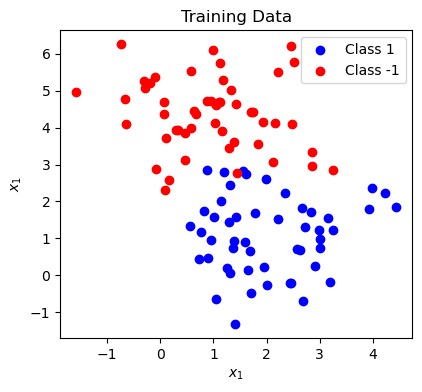

In [ ]:

# Generate synthetic classification data
X, y = make_blobs(n_samples=100, centers=2, random_state=0)
# Convert labels to -1, 1
y = 2 * y - 1

# Plot data
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], c='b', label='Class 1')
plt.scatter(X[y==-1][:, 0], X[y==-1][:, 1], c='r', label='Class -1')
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_1$")
plt.title('Training Data');

The idea here is that we will use a certain number of weak learners, and by boosting create a linear combination of these weak learners that has good predictive power. Try to adjust the number of estimators and the max_depth of the stumps to see what happens and build intuition.

In [ ]:
# Initialize weights
N = len(y)
w = np.ones(N) / N
n_estimators = 3 # feel free to adjust this number to use more weak_learners!

# Store models and their coefficients
weak_learners = []
alphas = []

# Training
for m in range(n_estimators):
    # Train weak learner (stump)
    stump = DecisionTreeClassifier(max_depth=1) # What happens when we adjust this? Try it.
    stump.fit(X, y, sample_weight=w)
    weak_learners.append(stump)

    # Get predictions
    pred = stump.predict(X)

    # Calculate error
    err = np.sum(w * (pred != y))

    # Calculate model importance
    # (called alpha because lambda is a keyword)
    alpha = 0.5 * np.log((1 - err) / err)
    alphas.append(alpha)

    # Update weights
    w = w * np.exp(-alpha * y * pred)
    w = w / np.sum(w)  # normalize

Now let's plot our results!

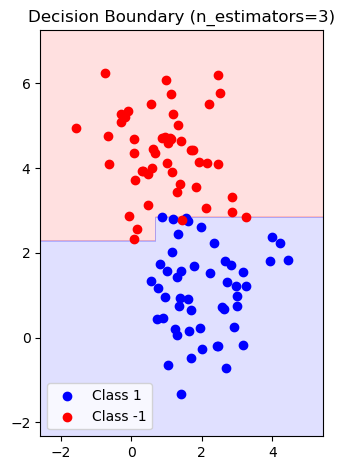

In [ ]:
# Plot decision boundary
def plot_decision_boundary(X, y, models, alphas, ax):
    h = 0.02  # step size in mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Combine predictions from all models
    Z = np.zeros((xx.ravel().shape[0],))
    for model, alpha in zip(models, alphas):
        Z += alpha * model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.sign(Z)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    cm = ListedColormap(['#FF9999', '#9999FF'])
    ax.contourf(xx, yy, Z, cmap=cm, alpha=0.3)
    ax.scatter(X[y==1][:, 0], X[y==1][:, 1], c='b', label='Class 1')
    ax.scatter(X[y==-1][:, 0], X[y==-1][:, 1], c='r', label='Class -1')
    ax.legend()

plt.subplot(122)
plot_decision_boundary(X, y, weak_learners, alphas, plt.gca())
plt.title(f'Decision Boundary (n_estimators={n_estimators})')
plt.tight_layout()
plt.show()

### Classification Example
We'll implement AdaBoost for a classification task using sklearn. Our example will use the spam dataset.

In [ ]:
df = pd.read_csv('data/spam.csv')
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_,char_freq_.1,char_freq_.2,char_freq_.3,char_freq_.4,char_freq_.5,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [ ]:
# Separate predictors from response
X = df.drop('spam', axis=1)
y = df['spam']
# X, y = datasets.load_breast_cancer(return_X_y=True)

# Initial 80/20 train/test split stratifying on response
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)
# Keep a copy of the original train split
X_train_full = np.copy(X_train)
y_train_full = np.copy(y_train)

# 20% of the initial train split will serve as validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=0, stratify=y_train)

In [ ]:
X_train.shape

(2944, 57)

### Random Forest Classifier for Comparison
Let's again observe the performance of random forest on train and OOB as the number of estimators in the ensemble increases.

In [ ]:
# Track train and OOB scores
train_scores = []
oob_scores = []

# Set some untuned model parameters
max_features = 'sqrt' #consider sqrt of total features at each split
max_depth = 5

# Instantiate a single RandomForestClassifier object
rf = RandomForestClassifier(n_estimators=1, # n_estimators will be overwritten in loop
                            max_features='sqrt',
                            max_depth=5,
                            oob_score=True,
                            warm_start=True,
                            random_state=0)

max_estimators = 200
n_estimator_range = range(1, max_estimators+1)
for n in n_estimator_range:
    rf.n_estimators = n
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    oob_scores.append(rf.oob_score_)

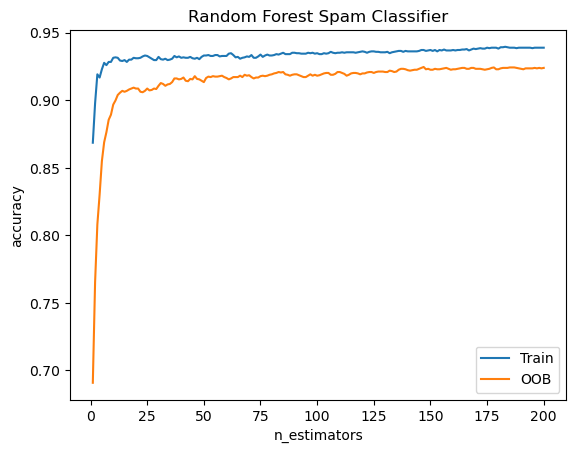

In [ ]:
# Create the trace plot
plt.plot(n_estimator_range, train_scores, label='Train')
plt.plot(n_estimator_range, oob_scores, label='OOB')
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.legend()
plt.title("Random Forest Spam Classifier");

In [ ]:
# Best num estimators based on OOB
# Q: Do we really care though?
rf_best_n_estimators = np.argmax(oob_scores)+1
rf_best_n_estimators

np.int64(147)

Let's fit and evaluate the final random forest model.

In [ ]:
# Refit on all the training data
# Q: do we really need to?
rf = RandomForestClassifier(n_estimators=rf_best_n_estimators,
                            max_features=max_features,
                            max_depth=max_depth,
                            random_state=0)
rf.fit(X_train_full, y_train_full)

,n_estimators,np.int64(147)
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
rf_train_acc = rf.score(X_train_full, y_train_full)
rf_test_acc = rf.score(X_test, y_test)
print(f"Random Forest Train Acc: {rf_train_acc:.2%}")
print(f"Random Forest Test Acc: {rf_test_acc:.2%}")

Random Forest Train Acc: 93.53%
Random Forest Test Acc: 94.25%


Certainly! Below is a markdown guide that you can include in your Jupyter notebook, describing the basic functionality of AdaBoostClassifier and GradientBoostingRegressor from scikit-learn. This guide covers important arguments, methods, and attributes relevant to these models.
[AdaBoostClassifier in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn-ensemble-adaboostclassifier)

The AdaBoostClassifier is an ensemble classifier in scikit-learn that combines multiple weak learners to create a strong learner. The model focuses on correctly classifying examples that were misclassified in previous iterations.

Key **arguments**

- `base_estimator:` The model to use as the base learner. Default is DecisionTreeClassifier initialized with max_depth=1.
- `n_estimators`: The maximum number of estimators at which boosting is terminated. In case of perfect fit, the learning procedure is stopped early.
- `learning_rate`: Weight applied to each classifier at each boosting iteration. A higher learning rate increases the contribution of each classifier.
- `random_state`: Controls the randomness of the estimator.

The standard **methods** found on sklearn classifiers plus something new

- `fit(X, y)`: Train the AdaBoost classifier on the training set (X, y).
- `predict(X)`: Predict class labels for samples in X.
- `score(X, y)`: Returns the mean accuracy on the given test data and labels.
- `predict_proba(X)`: Predict class probabilities for X.
- `staged_predict(X)`: **[NEW]** Return iterated predictions of the target at each stage for X.

Some useful **attributes** you may remember from our other tree-based ensembles

- `feature_importances_`: The impurity-based feature importances.
- `estimators_`: The collection of fitted base learners.

In [ ]:
#Training
max_depth = 1
lr = .5
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=max_depth),
                           n_estimators=500,
                           learning_rate=lr,
                           random_state=0)
ada.fit(X_train, y_train)

,estimator,DecisionTreeC...r(max_depth=1)
,n_estimators,500
,learning_rate,0.5
,algorithm,'deprecated'
,random_state,0
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [ ]:
#Predict
y_pred_train = ada.predict(X_train)
y_pred_val = ada.predict(X_val)

#Performance Evaluation
acc_boosting_training = accuracy_score(y_train, y_pred_train)*100
acc_boosting_val = accuracy_score(y_val, y_pred_val)*100

print("Ada Boost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_boosting_training))
print("Ada Boost:\tAccuracy, Val Set \t: {:0.2f}%".format(acc_boosting_val))

Ada Boost:	Accuracy, Training Set 	: 94.57%
Ada Boost:	Accuracy, Val Set 	: 94.43%


### Staged Scores

<div class="alert alert-success">
<h3>🏋🏻‍♂️ GROUP ACTIVITY: Staged Scores Plot</h3>
</div>

**Instructions:** Use the `staged_score` method to visualize AdaBoost's train and validation score as a function of the number of estimators. (Note: the staged_score method returns an iterable of scores computed after each boosting stage.) Consider the following questions in your implementation:

- How many estimators would you pick for your final model?
- Does this change with the choice of max_depth and learning rate? How so?
- Fit a final AdaBoost model with your tuned set of hyperparameters: n_estimators, max_depth, and learning_rate

best number of iterations 421


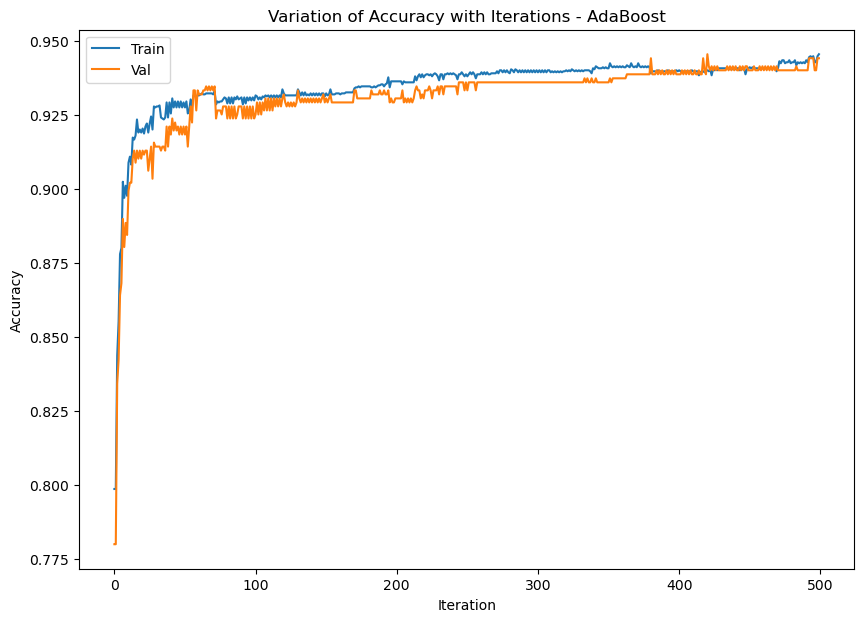

In [ ]:
# your code here
# BEGIN SOLUTION
# Plot Iteration based score
train_scores = list(ada.staged_score(X_train,y_train))
val_scores = list(ada.staged_score(X_val, y_val))

plt.figure(figsize=(10,7))
plt.plot(train_scores,label='Train')
plt.plot(val_scores,label='Val')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Variation of Accuracy with Iterations - AdaBoost")
plt.legend();
ada_best_n_estimators = np.array(val_scores).argmax() + 1
print('best number of iterations', ada_best_n_estimators)
# END SOLUTION

In [ ]:
# your code here
# BEGIN SOLUTION
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=max_depth),
                           n_estimators=int(ada_best_n_estimators*1.25),
                           learning_rate=lr,
                            random_state=0)
ada.fit(X_train_full, y_train_full)

ada_accuracy = ada.score(X_test, y_test)
print(f"Test Accuracy of Ada Boost Classifier is: {ada_accuracy:.2%}")
# END SOLUTION

Test Accuracy of Ada Boost Classifier is: 95.11%


1. **Why we add the 1.25 multiplier to get the final best number of estimators**: The optimal n_estimators is found on a validation subset. The final model trains on the full training set, which is larger. With more data, the model can typically use more estimators before overfitting, so adding 25% provides a small buffer. It also accounts for validation variance and avoids stopping too early.

2. **Tradeoffs between max_depth and n_estimators**:
- Higher max_depth means each tree is more complex, so you typically need fewer trees to prevent fast overfitting.
- Lower max_depth means each tree is simpler, so you typically need more trees to reach good performance.
3. **Tradeoffs between learning rate and n_estimators**:
- Lower learning rate means each tree contributes less, so you typically need more trees to reach good performance.
- Higher learning rate means each tree contributes more, so you typically need fewer trees.

## Gradient Boosting
### Theory
Gradient Boosting is another boosting technique that builds trees one at a time, where **each new tree is fit on the residual of the current ensemble**. This process can be conceptualized as a form of gradient descent in function space.

- Start with a model, $T^{(m)}$
- The gradient boosting algorithm improves on $T^{(m)}$ by constructing a new model that adds an weak estimator $s$ to provide a better model:
$$T^{(m+1)}(x)=T^{(m)}(x)+s(x)$$

- To find $s$, the gradient boosting solution starts with the observation that a perfect **s** would imply

$$T_{m+1}(x)=T_{m}(x)+s(x)=y$$

- or, equivalently solving for $s$,

$$s(x)=y-T_{m}(x)$$

- Therefore, gradient boosting will fit $s$ to the residual $y-T_{m}(x)$

- To prevent us from quickly overfitting, a learning rate, $\lambda$ is added to dampen the contribution of each weak learner's contribution to the ensemble.
$$T^{(M)} = \sum_{m=1}^{M} \lambda s^{(m)}$$

### Gradient Boosting Algorithm Implementation

Let's implement gradient boosting for this toy regression problem

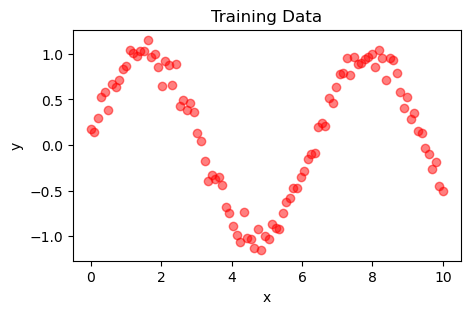

In [ ]:
# Generate & plot synthetic regression data
np.random.seed(0)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X.ravel()) + np.random.normal(0, 0.1, 100)

plt.figure(figsize=(5, 3))
plt.scatter(X, y, color='red', alpha=0.5)
plt.title('Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# Gradient Boosting Algorithm
n_estimators = 9
learning_rate = 0.1

# Initialize first model
T = np.zeros_like(y)
trees = []

# Training
for m in range(n_estimators):
    # Compute residuals
    residuals = y - T

    # Fit weak learner to residuals
    tree = DecisionTreeRegressor(max_depth=2)
    tree.fit(X, residuals)
    trees.append(tree)

    # Update model
    T += learning_rate * tree.predict(X)

...and visualize the results!

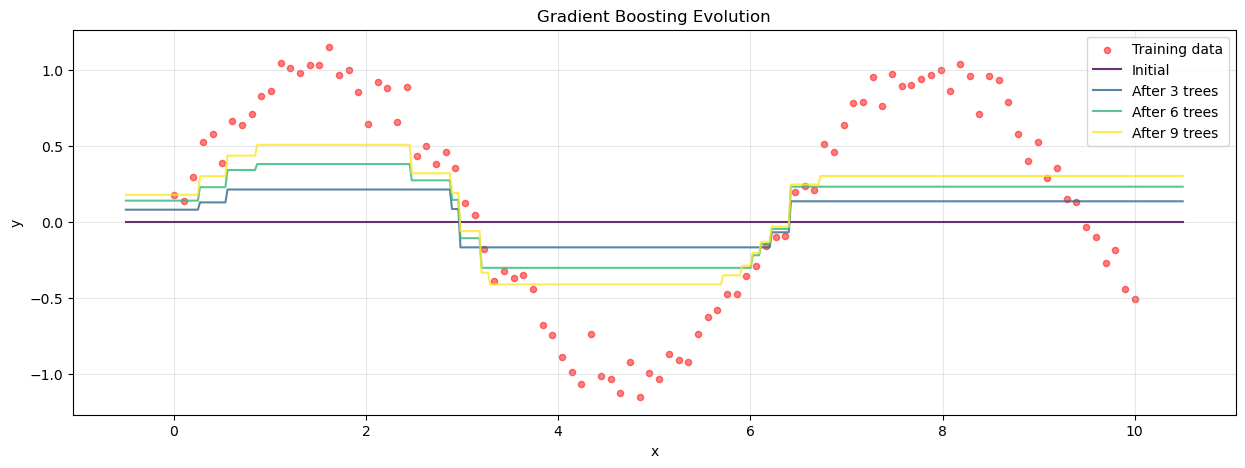

In [ ]:
# Here's out visualization of the gradient boosting results
# Create dense grid for smooth predictions
X_pred = np.linspace(-0.5, 10.5, 500).reshape(-1, 1)

# Get predictions for each stage we want to plot
stages_to_plot = [0, 3, 6, 9]
staged_predictions = []

for n_trees in stages_to_plot:
    # Get prediction from ensemble of n_trees
    pred = np.zeros(len(X_pred))
    for i in range(n_trees):
        pred += learning_rate * trees[i].predict(X_pred)
    staged_predictions.append(pred)

# Plot the stuff!
plt.figure(figsize=(15, 5))
plt.scatter(X, y, color='red', alpha=0.5, label='Training data', s=20)

colors = plt.cm.viridis(np.linspace(0, 1, len(staged_predictions)))
for i, pred in enumerate(staged_predictions):
    label = 'Initial' if i == 0 else f'After {stages_to_plot[i]} trees'
    plt.plot(X_pred, pred, color=colors[i], alpha=0.8, label=label)

plt.title('Gradient Boosting Evolution')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Regression Example
In our regression example, we'll apply Gradient Boosting to the California Housing dataset.

In [ ]:
X, y = datasets.fetch_california_housing(return_X_y=True, as_frame=True)

In [ ]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [ ]:
X.shape, y.shape

((20640, 8), (20640,))

In [ ]:
# Initial 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# Keep a copy of the original train split
X_train_full = np.copy(X_train)
y_train_full = np.copy(y_train)

# 20% of the initial train split will serve as validation
# (We'll use this val set for boosting ensembles that don't have OOB)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=0)

Again, we'll use a random forest for comparison.
Unfortunately, GridSearchCV can be very slow because it has to fit a new model to score on each validation fold. We shouldn't have to do CV at all because we have OOB! But this requires a bit of manual implementation to use the out-of-bag scores as our validation score for each combination of hyperparameters.

In [ ]:
# You can try different parameters
# but a big grid is still slow
param_grid = {
    "max_depth": [None, 64],
    "max_features": ["sqrt", 4],
    "min_samples_leaf": [1, 3],
}

best_score = -np.inf
best_model = None
best_params = None
n_estimators=500

for params in ParameterGrid(param_grid):
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        oob_score=True,
        bootstrap=True,
        n_jobs=-1,
        random_state=42,
        **params,
    )
    rf.fit(X_train_full, y_train_full)
    score = rf.oob_score_

    if score > best_score:
        best_score = score
        best_model = rf
        best_params = params

print("Best params:", best_params)
print("Best OOB score:", best_score)

Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}
Best OOB score: 0.8198802037794792


In [ ]:
# Train & Test scores
best_model.score(X_train_full, y_train_full), best_model.score(X_test, y_test)

(0.9755864876136776, 0.8187064466437226)

### GradientBoostingRegressor in scikit-learn

SKLearn's [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) implements gradient boosting for regression tasks. It builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions.

#### Key Arguments

- `n_estimators`: The number of boosting stages to be run. More stages increase the model complexity.
- `learning_rate`: Learning rate shrinks the contribution of each tree. There is a trade-off between `learning_rate` and `n_estimators`.
- `max_depth`: Maximum depth of the individual regression estimators. Controls the depth of the trees.
- `min_samples_split`: The minimum number of samples required to split an internal node.
- `random_state`: Controls the randomness of the estimator.
- `loss`: The loss function to be optimized. 'squared_error' refers to the mean square error.

#### Important Methods

- `fit(X, y)`: Fit the gradient boosting model.
- `predict(X)`: Predict continuous values for X.
- `score(X, y)`: Returns the coefficient of determination \( R^2 \) of the prediction.
- `staged_predict(X)`: Return iterated predictions of the target at each stage for X.

#### Key Attributes

- `feature_importances_`: The impurity-based feature importances.
- `estimators_`: A list of the trees in the ensemble.
- `loss_`: The concrete `Loss` object used.

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ GROUP ACTIVITY:</strong> Tune a GradientBoostingRegressor</div>  

**Instructions:** Use cross-validation or the single validation split to tune the parameters of your gradient boosting model and call it `gb`.

Can you beat the random forest? Remember, model selection can't be done by looking at the test score!!

In [ ]:
# your code here
# BEGIN SOLUTION
# Tune learning_rate and max_depth with CV, using a large n_estimators cap
param_grid = {
    "learning_rate": [0.1, 0.2],
    "max_depth": [2, 3],
}

gb_base = GradientBoostingRegressor(
    n_estimators=1750,   # big upper bound; we'll choose a smaller best_n later
    random_state=0
)

grid = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

grid.fit(X_train, y_train)
print("Best params (without n_estimators):", grid.best_params_)

# Use staged predictions on the validation set to pick n_estimators
gb_cv = grid.best_estimator_
val_mse = []

for i, y_pred in enumerate(gb_cv.staged_predict(X_val), start=1):
    val_mse.append(mean_squared_error(y_val, y_pred))

best_n = np.argmin(val_mse) + 1
print("Best n_estimators from staged scores:", best_n)

# Refit final model on train with tuned params + best_n
best_params = dict(grid.best_params_)
best_params["n_estimators"] = best_n

gb = GradientBoostingRegressor(random_state=0, **best_params)
gb.fit(X_train_full, y_train_full)
# END SOLUTION

Best params (without n_estimators): {'learning_rate': 0.1, 'max_depth': 3}
Best n_estimators from staged scores: 1580


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,np.int64(1580)
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [ ]:
# BEGIN SOLUTION
gb.score(X_train_full, y_train_full), gb.score(X_test, y_test)
# END SOLUTION

(0.9197628304353977, 0.8434409371953157)

## Introduction to XGBoost
XGBoost stands for eXtreme Gradient Boosting and is known for its performance and speed. It's a scalable and accurate implementation of gradient boosting, which has proven effective in numerous machine learning competitions.

We'll briefly go through a coding example using the `xgboost` library to demonstrate its usage.

[https://xgboost.readthedocs.io/en/stable/python/python_intro.html](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)



-------

### XGBoost

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec12/fig/kaggle.png?raw=1" alt="tree_adj" width="50%"/>


----------

### What is XGBoost and why is it so good!?
 - Based on Gradient Boosting
 - XGBoost = **eXtreme Gradient Boosting**; refers to the engineering goal to push the limit of computations resources for boosted tree algorithm

**Accuracy:**
 - XGBoost however uses a **more regularized model formalizaiton to control overfitting** (=better performance) by both L1 and L2 regularization.
 - Tree Pruning methods: more shallow tree will also prevent overfitting
 - Improved convergence techniques (like early stopping when no improvement is made for X number of iterations)
 - Built-in Cross-Validaiton

**Computing Speed:**
 - Special Vector and matrix type data structures for faster results.
 - Parallelized tree building: using all of your CPU cores during training.
 - Distributed Computing: for training very large models using a cluster of machines.
 - Cache Optimization of data structures and algorithm: to make best use of hardware.

**XGBoost is building boosted trees in parallel? What? How?**
- No: Xgboost doesn't run multiple trees in parallel, you need predictions after each tree to update gradients.
- Rather it does the parallelization WITHIN a single tree my using openMP to create branches independently.

## 6. Use XGBoost: Extreme Gradient Boosting

In [ ]:
# Let's install XGBoost
# ! pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
# Initialize the XGBoost regressor model
model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=1750,
                         max_depth=3,
                         learning_rate=0.1,
                         random_state=0)

# Train the model
model.fit(X_train_full, y_train_full)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

In [ ]:
print("XGBoost Test R^2:", r2_score(y_test, y_pred))

XGBoost Test R^2: 0.8491542722775145


In [ ]:
# This will take a while to run
# Let's actually tune it!
param_grid = {
    'max_depth': [4,3,2],
    'n_estimators': [1750],
    'learning_rate': [0.15, 0.1, 0.05],
}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    eval_metric='rmse'
)

# Note refit=True (default) means it will automatically refit on full training data
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error'
)

start = time.time()
grid_search.fit(X_train_full, y_train_full)
end = time.time()
xgb_tune_time = (end-start)/60

print("Best parameters:", grid_search.best_params_)
print(f"XGBoost Tuning Time: {xgb_tune_time:.2f} minutes")

Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 1750}
XGBoost Tuning Time: 1.49 minutes


In [ ]:
grid_search.best_estimator_.score(X_test, y_test)

0.8528265454224767


----------

**Overview of all the tree algorithms:** [Source](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

<img src="https://github.com/Harvard-CS1090A/2025-public/blob/main/sec12/fig/trees.png?raw=1" alt="tree_adj" width="75%"/>





----------

## Optional: Example to better understand Bias vs Variance tradeoff.

A central notion underlying what we've been learning in lectures and sections so far is the trade-off between overfitting and underfitting. If you remember back to Homework 3, we had a model that seemed to represent our data accurately. However, we saw that as we made it more and more accurate on the training set, it did not generalize well to unobserved data.

As a different example, in face recognition algorithms, such as those used to unlock a smartphone, a too-accurate model would be unable to identity someone who styled their hair differently that day. The reason is that our model may learn irrelevant features in the training data. On the contrary, an insufficiently trained model would not generalize well either. For example, it was recently reported that a face mask could sufficiently fool the smartphone.

A widely used solution in statistics to reduce overfitting consists of adding structure to the model, with something like regularization. This method favors simpler models during training.

The bias-variance dilemma is closely related.
- The **bias** of a model quantifies how precise a model is across training sets.
- The **variance** quantifies how sensitive the model is to small changes in the training set.
- A **robust** model is not overly sensitive to small changes.
- **The dilemma involves minimizing both bias and variance**; we want a precise and robust model. Simpler models tend to be less accurate but more robust. Complex models tend to be more accurate but less robust.

**How to reduce bias:**
 - **Use more complex models, more features, less regularization,** ...
 - **Boosting:** attempts to improve the predictive flexibility of simple models. Boosting uses simple base models and tries to “boost” their aggregate complexity.

**How to reduce variance:**
 - **Early Stopping:** Its rules provide us with guidance as to how many iterations can be run before the learner begins to over-fit.
 - **Pruning:** Pruning is extensively used while building related models. It simply removes the nodes which add little predictive power for the problem in hand.
 - **Regularization:** It introduces a cost term for bringing in more features with the objective function. Hence it tries to push the coefficients for many variables to zero and hence reduce cost term.
 - **Train with more data:** It won’t work every time, but training with more data can help algorithms detect the signal better.
 - **Ensembling:** Ensembles are machine learning methods for combining predictions from multiple separate models. For example:
   - **Bagging** attempts to reduce the chance of overfitting complex models: Bagging uses complex base models and tries to “smooth out” their predictions.

🌈 **The End**